In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import re
from collections import Counter
import heapq
from operator import itemgetter
from multiprocessing import Pool
from nltk.tokenize import word_tokenize 
import sys
from matplotlib import figure
import matplotlib.pyplot as plt
!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud,  ImageColorGenerator
import random
import numpy as np
from keras.layers import Embedding
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Dropout
import keras
from keras.utils import to_categorical
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
from google.colab import drive 


drive.flush_and_unmount()
#drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fake_covid_news.csv to fake_covid_news.csv


In [ ]:
uploaded = files.upload()

Saving real_covid_news.csv to real_covid_news.csv


In [ ]:
fake = pd.read_csv('/content/drive/My Drive/covid_data/fake_covid_news.csv')
real = pd.read_csv('/content/drive/My Drive/covid_data/real_covid_news.csv')

In [ ]:
fake

,type,title,newstitle,publish_date,content
0,post,Facebook posts shared in at least three countr...,NaN,NaN,NaN
1,article,Wisconsin is Òclearly seeing a decline in COVI...,"""Wisconsin Legislature Takes Gov. Evers to Court""",NaN,speaker robin vos r rochester and senate major...
2,post,Facebook posts claim a child who is infected w...,NaN,NaN,NaN
3,post,IndiaÕs Ministry of Home Affairs banning citiz...,NaN,NaN,NaN
4,post,"42 Democratic senators, plus two Independents,...",NaN,NaN,NaN
...,...,...,...,...,...
861,NaN,NaN,NaN,NaN,"""The outbreak began because people ate bat soup"""
862,NaN,NaN,NaN,NaN,"""5G helps SARS-CoV-2 spread"""
863,NaN,NaN,NaN,NaN,"""Drinking alcohol reduces the risk of infection"""
864,NaN,NaN,NaN,NaN,"""Injecting or consuming bleach or disinfectant..."


In [ ]:
real

,type,title,newstitle,publish_date,content
0,article,Coronavirus Outbreak: Live Updates,"""Coronavirus Outbreak: Daily Updates""",NaN,experts warn most states that are reopening st...
1,article,"Screen Time Doesn’t Hurt Kids’ Social Skills, ...","""Screen Time Doesn't Hurt Kids' Social Skills,...",NaN,a new study finds an increase in screen time d...
2,article,Here’s Exactly Where We Are with Vaccines and ...,"""Where We're at with Vaccines and Treatments f...",NaN,scientists around the world are working on a n...
3,article,Here’s What Happens to the Body After Contract...,"""Here's What Happens to the Body After Contrac...",NaN,coronaviruses cause respiratory illnesses so t...
4,article,Why You Should Be Skeptical of Early Results o...,"""Why You Should Be Skeptical of Leaked Results...",NaN,medical experts are studying if remdesivir can...
...,...,...,...,...,...
3048,NaN,NaN,NaN,NaN,How can we protect people seeking tuberculosis...
3049,NaN,NaN,NaN,NaN,Can tuberculosis and COVID-19 be tested on the...
3050,NaN,NaN,NaN,NaN,Should all people being evaluated for tubercul...
3051,NaN,NaN,NaN,NaN,Is tuberculosis treatment different in people ...


In [ ]:
# remove punctuation in each news article

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, '')
    return x

In [ ]:
# replace numbers with # because most embeddings have processed thier text like this

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [ ]:
# remove contractions 

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [ ]:
def remove_stopwords(text):
    clean_news = [] #create new list to store clean tweet
    for word in text:
        if word not in stop_words: #do not append stopwords or punctuation
            clean_news.append(word)
    return clean_news

In [ ]:
def apreprocess_text1(news):
    news = clean_text(news)
    news = clean_numbers(news)
    news = replace_contractions(news)
    news = word_tokenize(news)
    news = remove_stopwords(news)
    return news

In [ ]:
real_sub = list(real['content'])


In [ ]:
for news in real_sub:
    print(news)

In [ ]:
# preprocessed real tweets
def apreprocess_text1(news):
    news = clean_text(news)
    news = clean_numbers(news)
    news = replace_contractions(news)
    news = word_tokenize(news)
    news = remove_stopwords(news)
    return news
import nltk
nltk.download('punkt')   
final_real = []
for content in real_sub:
    outcome = apreprocess_text1(content)
    final_real.append(outcome)
final_real

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[['experts',
  'warn',
  'states',
  'reopening',
  'still',
  'nt',
  'enough',
  'testing',
  'us',
  'states',
  'start',
  'loosen',
  'stay',
  'home',
  'orders',
  'experts',
  'warn',
  'covid',
  '#',
  '#',
  'could',
  'come',
  'back',
  'enough',
  'testing',
  'according',
  'associated',
  'press',
  'significant',
  'number',
  'states',
  'reopening',
  'still',
  'meeting',
  'key',
  'testing',
  'benchmarks',
  'suggested',
  'harvards',
  'global',
  'health',
  'institute',
  'according',
  'institute',
  'world',
  'health',
  'organization',
  'enough',
  'testing',
  'done'],
 ['new',
  'study',
  'finds',
  'increase',
  'screen',
  'time',
  'nt',
  'hurt',
  'kids',
  'social',
  'skills',
  'getty',
  'images',
  'new',
  'study',
  'found',
  'despite',
  'time',
  'spent',
  'smartphones',
  'todays',
  'young',
  'people',
  'socially',
  'skilled',
  'previous',
  'generation',
  'researchers',
  'compared',
  'teacher',
  'parent',
  'evaluations',
  '

In [ ]:
fake_sub_na_dropped = fake['content']
fake_sub_na_dropped = fake_sub_na_dropped.dropna()
fake_sub_na_dropped = list(fake_sub_na_dropped)


In [ ]:
# preprocessed fake tweets
final_fake = []
for content in fake_sub_na_dropped:
    outcome = preprocess_text(content)
    final_fake.append(outcome)


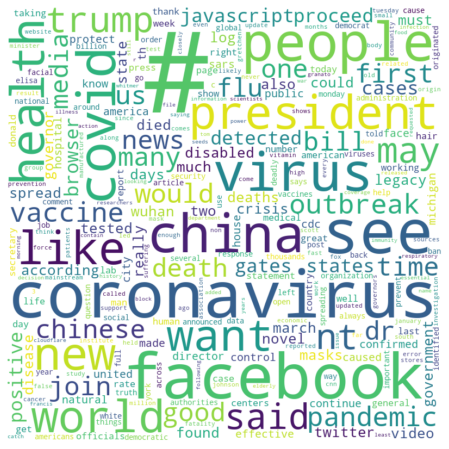

In [ ]:
#fake news word cloud

counts = dict()
for sentence in final_fake:
    for word in sentence:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=1000,
                relative_scaling=0.21,
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(counts)
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

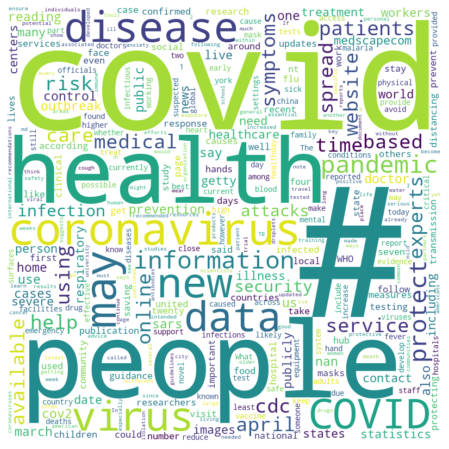

In [ ]:
# real news wordcloud

counts = dict()
for sentence in final_real:
    for word in sentence:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=1000,
                relative_scaling=0.21,
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(counts)
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Preprocess data for model

- fake news data has 378 observations without NA values 
- real news dtaa has 2720 observations without NA values 
- ratio of reall to fake: .1389
- data will be split 80% train and 20% test

In [ ]:
import sklearn
fake_model = fake['content']
fake_model = fake_model.dropna()
fake_model = list(fake_model)
#len(fake_model)

# split betweet train and test for fake data 
random.seed(1)
train_fake, test_fake = sklearn.model_selection.train_test_split(fake_model, train_size=302, test_size=76)
print("test length: ", len(test_fake))
print("train length: ", len(train_fake))

test length:  76
train length:  302


In [ ]:
real_model = real['content']
real_model = real_model.dropna()
real_model = list(real_model)
#len(real_model)

# split betweet train and test for fake data 
random.seed(1)
train_real, test_real = sklearn.model_selection.train_test_split(real_model, train_size=2176, test_size=544)
print("test length: ", len(test_real))
print("train length: ", len(train_real))

test length:  544
train length:  2176


In [ ]:
#combine lists for fake and real news for train set

train = train_fake + train_real

labels_train = [] # create labels for each article

for i in range(302): # 1 is for fake news
    labels_train.append(0)
    
for i in range(2176): # 0 is for real news
    labels_train.append(1)

In [ ]:
#combine lists for fake and real news for test set

test = test_fake + test_real

labels_test = [] # create labels for each article

for i in range(76): # 1 is for fake news
    labels_test.append(0)
    
for i in range(544): # 0 is for real news
    labels_test.append(1)

In [ ]:
# convert to one hot vector so that it can be processed by NN

labels_train = to_categorical(labels_train)

labels_test = to_categorical(labels_test)

In [ ]:
# convert the tweets to an integer encoded version  
# one_hot() creates hash of each word

# for training set
train_encoded = [one_hot(d,10000) for d in train]

# for test set
test_encoded = [one_hot(d, 10000) for d in test]

In [ ]:
# keras prefers inputs vectroized and all the same length so we must pad

# find the maxmimum number of words in one tweet

largest = len(test_encoded[0])

for tweet in test_encoded:
    if len(tweet) > largest:
        largest = len(tweet)
        
print("The longest news has {:d} number of words".format(largest))

max_tweet_length = largest


train_encoded = sequence.pad_sequences(train_encoded, maxlen = max_tweet_length)

# repeat for test set

max_tweet_length = largest
test_encoded = sequence.pad_sequences(test_encoded, maxlen = max_tweet_length)

The longest news has 401 number of words


### Prepare non-covid news data

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
uploaded = files.upload()

Saving submit.csv to submit.csv


In [ ]:
# data source: https://www.kaggle.com/c/fake-news/discussion/57773

reg_news_test1 = pd.read_csv('/content/drive/My Drive/covid_data/regular news/test.csv') # 80% of data
reg_news_train = pd.read_csv('/content/drive/My Drive/covid_data/regular news/train.csv') # 20% of data
reg_news_labels = pd.read_csv('/content/drive/My Drive/covid_data/regular news/submit.csv')

In [ ]:
reg_news_train

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [ ]:
reg_news_test1

In [ ]:
reg_news_labels

In [ ]:
reg_news_test = pd.merge(reg_news_test1,reg_news_labels,on='id')
reg_news_test

# 1 is fake, 0 is real

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1
...,...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,0
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,1
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,0
5198,25998,300 US Marines To Be Deployed To Russian Borde...,NaN,« Previous - Next » 300 US Marines To Be Deplo...,1


In [ ]:
# balanced dataset: 0 to 1 ratio is .449
reg_news_test.groupby('label').count()

,id,title,author,text
label,,,,
0,2339,2334,2218,2339
1,2861,2744,2479,2854


In [ ]:
# balanced dataset: 0 to 1 ratio is .499
reg_news_train.groupby('label').count()

,id,title,author,text
label,,,,
0,10387,10387,10361,10387
1,10413,9855,8482,10374


In [ ]:
# preprocessed training data
reg_news_train2 = reg_news_train.dropna()
reg_news_train2 = reg_news_train2[:10000]
reg_news_train1 = list(reg_news_train2['text'])
reg_news_train_labels = list(reg_news_train2['label'])

#reg_train = []
#for text in reg_news_train1:
#    outcome = preprocess_text(text)
#    reg_train.append(outcome)
#reg_train

In [ ]:
# preprocessed test data

reg_news_test2 = reg_news_test.dropna()
reg_news_test2 = reg_news_test2[:2500]
reg_news_test1 = list(reg_news_test2['text'])

reg_news_test_labels = list(reg_news_test2['label'])

#reg_test = []
#for text in reg_news_test1:
#    outcome = preprocess_text(text)
#    reg_test.append(outcome)
#reg_test

- reg_train: training text 
- reg_news_train_labels: traning labels 
- reg_test: test text 
- reg_news_test_labels:test labels

In [ ]:
# convert to one hot vector so that it can be processed by NN

reg_labels_train = to_categorical(reg_news_train_labels)

reg_labels_test = to_categorical(reg_news_test_labels)

In [ ]:
# convert the tweets to an integer encoded version  
# one_hot() creates hash of each word

# for training set
reg_train_encoded = [one_hot(d,10000) for d in reg_news_train1]

# for test set
reg_test_encoded = [one_hot(d, 10000) for d in reg_news_test1]

In [ ]:
# keras prefers inputs vectroized and all the same length so we must pad

# find the maxmimum number of words in one tweet

largest = len(reg_train_encoded[0])

for news in reg_train_encoded:
    if len(news) > largest:
        largest = len(news)
        
print("The longest news has {:d} number of words".format(largest))

max_tweet_length = largest


reg_train_encoded = sequence.pad_sequences(reg_train_encoded, maxlen = max_tweet_length)

# repeat for test set

max_tweet_length = largest
reg_test_encoded = sequence.pad_sequences(reg_test_encoded, maxlen = max_tweet_length)

The longest news has 21041 number of words


In [ ]:
# verbose 0: silent, doesnt show anything
# verbose 1: shows you progress bad
# verbose 2: shows one line per epoch

# check it out on keras, if u dont know how many epochs to do with model checkpoint, u can save on the best loss its ever seen or best validation accuracy its ever seen

# saves a model or weights at some interval so the model can be loaded later to continue training from the state saved

from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint(
    filepath = "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5", # what to put here?
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True, # least loss... as opposed to saving each model at the end of each epoch
    save_weights_only = True, #
    mode = 'min') # min bc we want to minimize loss. max is for val_acc


# stops training when a monitored metric has stopped improving

from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor = 'val_loss', # monitor the loss
    min_delta = 0.01, # wait patience periods for it to do better by the min delta, if it does not then stops training
    patience = 2, # number of epochs with no improvement
    verbose = 1, 
    mode = 'min')

#from keras.callbacks import LearningRateScheduler

#lrs = LearningRateScheduler(lambda epoch: 1./epoch) # at the end of each epoch change the learning rate 


# reduce learning rate when a metric has stopped improving 

from keras.callbacks import ReduceLROnPlateau # hardly uses this

# models often benefit from reducing the learning rate once learning stagnates
rlrop = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 2, # if model does not see improvement by epsilon after 2 epochs then reduce the learning rate
    verbose = 0,
    mode = 'min',
    epsilon = 0.0001,
    cooldown = 2, # wait 2 epochs before monitoring the metrics again
    min_lr = 0 # minimum learning rate
 )



In [ ]:
reg_train_encoded2 = np.array(reg_train_encoded)
reg_news_train_labels2 = np.array(reg_news_train_labels)
reg_test_encoded2 = np.array(reg_test_encoded)
reg_news_test_labels2 = np.array(reg_news_test_labels)

In [ ]:
######################### temp code ##################################
data = reg_news_train 

data=data.drop(['title','author','id'],axis=1)
data=data.dropna()


X=data['text']
y=data['label']

X=X.reset_index()
X=X.drop(['index'],axis=1)

y=y.reset_index()
y=y.drop(['index'],axis=1)

#re is regular expressions used for identifying only words in the text and ignoring anything else
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


ps = PorterStemmer()
corpus = []
#each row of the dataset is considered here.everything except the alphabets are removed ,stopwords are also being removed here .the text is converted in lowercase letters and stemming is performed
#lemmatisation can also be used here at the end a corpus of sentences is created
nltk.download('stopwords')
stop_words = stopwords.words('english')

for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ',X['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)

voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

sent_length=25

#using padding for creating equal length sentences
from tensorflow.keras.preprocessing.sequence import pad_sequences



embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

X_final=np.array(embedded_docs)
y_final=np.array(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
fake = pd.read_csv('/content/drive/My Drive/covid_data/fake_covid_news.csv')
real = pd.read_csv('/content/drive/My Drive/covid_data/real_covid_news.csv')

# create outcome variable in both datasets
fake['outcome'] = 1
real['outcome'] = 0

# combine both datasets
real_fake = pd.concat([fake, real], axis=0)
######################### temp code ##################################
data = real_fake 

data=data[['content', 'outcome']]
print("length before drop", len(data))
data=data.dropna()
print("length after drop", len(data))


X=data['content']
y=data['outcome']

X=X.reset_index()
X=X.drop(['index'],axis=1)

y=y.reset_index()
y=y.drop(['index'],axis=1)

#re is regular expressions used for identifying only words in the text and ignoring anything else
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


ps = PorterStemmer()
corpus = []
#each row of the dataset is considered here.everything except the alphabets are removed ,stopwords are also being removed here .the text is converted in lowercase letters and stemming is performed
#lemmatisation can also be used here at the end a corpus of sentences is created
nltk.download('stopwords')
stop_words = stopwords.words('english')

for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ',X['content'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)

voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

sent_length=25

#using padding for creating equal length sentences
from tensorflow.keras.preprocessing.sequence import pad_sequences



embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

X_final=np.array(embedded_docs)
y_final=np.array(y)

from sklearn.model_selection import train_test_split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

length before drop 3919
length after drop 3098
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(len(data))
print("Covid x train: ", len(Xc_train))
print("Covid y train: ", len(yc_train))
print("Covid x test: ", len(Xc_test))
print("Covid y test: ", len(yc_test))

print("Regular x train: ", len(X_train))
print("Regular y train: ", len(y_train))
print("Regular x test: ", len(X_test))
print("Regular y test: ", len(y_test))

3098
Covid x train:  2478
Covid y train:  2478
Covid x test:  620
Covid y test:  620
Regular x train:  16608
Regular y train:  16608
Regular x test:  4153
Regular y test:  4153


In [ ]:
## Creating LSTM neural network

model= keras.Sequential()
model.add(keras.layers.Embedding(10000, 16))
model.add(Dropout(0.3))
model.add(keras.layers.LSTM(256))
model.add(Dropout(.3))
model.add(keras.layers.Dense(1, activation = "sigmoid")) 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.save('reg_news_model1.hdf5')
print(model.summary())



fitModel = model.fit(#reg_train_encoded2, 
                     #reg_news_train_labels2, 
                     train_encoded,labels_train,
                     validation_data=(test_encoded,labels_test),
                     epochs =10, 
                     batch_size = 64, # not using full batch since num samples > 2000
                     #validation_data = (reg_test_encoded2, reg_news_test_labels2), 
                     verbose = 1,
                     callbacks = [mc, es, rlrop])

print(fitModel)

In [ ]:
yhat_probs2 = model.predict(Xc_test, verbose=0)
from sklearn.metrics import classification_report, accuracy_score
print("accuracy score: {}".format(accuracy_score(yc_test, yhat_probs2.round())))
print(classification_report(yc_test, yhat_probs2.round()))

accuracy score: 0.9403225806451613
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       531
           1       0.86      0.70      0.77        89

    accuracy                           0.94       620
   macro avg       0.91      0.84      0.87       620
weighted avg       0.94      0.94      0.94       620



In [ ]:
model2= keras.Sequential()
model2.add(keras.layers.Embedding(10000, 16))
model2.add(Dropout(0.3))
model2.add(keras.layers.LSTM(256))
model2.add(Dropout(.3))
model2.add(keras.layers.Dense(1, activation = "sigmoid")) 
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())


for j in range(1, 11): 
  for i in range(1, 17):
    end = i*1000
    beg = end - 1000
    model2.train_on_batch(
      x = X_train[beg:end],
     y = y_train[beg:end])
    
# 2478 train_encoded 
# 2478 labels_train
#yc_train = np.asarray(labels_train).astype('float32').reshape((-1,1))

for j in range(1, 4): 
  for i in range(1, 2):
    end = i*1000
    beg = end - 1000
    model2.train_on_batch(
      x = Xc_train[beg:end],
      y = yc_train[beg:end])
  model2.train_on_batch(
      x = Xc_train[2000:2478],
      y = yc_train[2000:2478])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               279552    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 439,809
Trainable params: 439,809
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# predicting covid data on model2

yhat_probs2 = model2.predict(Xc_test, verbose=0)
from sklearn.metrics import classification_report, accuracy_score
print("accuracy score: {}".format(accuracy_score(yc_test, yhat_probs2.round())))
print(classification_report(yc_test, yhat_probs2.round()))

accuracy score: 0.7612903225806451
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       531
           1       0.23      0.29      0.26        89

    accuracy                           0.76       620
   macro avg       0.56      0.57      0.56       620
weighted avg       0.78      0.76      0.77       620



In [ ]:
yhat_probs2 = model2.predict(X_test, verbose=0)
from sklearn.metrics import classification_report, accuracy_score
print("accuracy score: {}".format(accuracy_score(y_test, yhat_probs2.round())))
print(classification_report(y_test, yhat_probs2.round()))

accuracy score: 0.6525403322899109
              precision    recall  f1-score   support

           0       0.62      0.81      0.70      2079
           1       0.72      0.49      0.59      2074

    accuracy                           0.65      4153
   macro avg       0.67      0.65      0.64      4153
weighted avg       0.67      0.65      0.64      4153



In [ ]:
# model down here covid

from keras.models import load_model
#modelc = keras.Sequential() # sequential groups a stack of layers

#modelc.add(keras.layers.Embedding(10000, 16)) 
#modelc.load_weights('/content/reg_news_model01.hdf5')
modelc = load_model('/content/reg_news_model1.hdf5', include_top = False)

for i in range(5):
  modelc.layers[i].trainable = False

# dropout is a regularization technique that aims to reduce the complexity of the model to prevent overfitting
# with dropout, you randomly deactivate certain neurons, layer needs to be tuned
#modelc.add(Lambda(lambda x: tf.expand_dims(modelc.output, axis=-1))
modelc.add(keras.layers.LSTM(256, dropout = 0.5))

# a dropout layer is a fully connected nn layer where each input node is connected to each output node
modelc.add(keras.layers.Dense(1, activation = "sigmoid")) # common to put dense layer before output

print(modelc.summary())

modelc.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) # look up optimizer and loss

fitModelc = modelc.fit(train_encoded, 
                     labels_train, 
                     epochs =10, 
                     batch_size = 64, # not using full batch since num samples > 2000
                     validation_data = (test_encoded, labels_test), 
                     verbose = 1,
                    callbacks = [tb, mc, es, rlrop])

print(fitModel)

In [ ]:
len(labels_test)
yc_test = np.asarray(labels_test).astype('float32').reshape((-1,1))
len(yc_test)
print(labels_test)
print(labels_train)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
len(labels_train)

2478

In [ ]:
print(fake)

        type  ...                                            content
0       post  ...                                                NaN
1    article  ...  speaker robin vos r rochester and senate major...
2       post  ...                                                NaN
3       post  ...                                                NaN
4       post  ...                                                NaN
..       ...  ...                                                ...
861      NaN  ...   "The outbreak began because people ate bat soup"
862      NaN  ...                       "5G helps SARS-CoV-2 spread"
863      NaN  ...   "Drinking alcohol reduces the risk of infection"
864      NaN  ...  "Injecting or consuming bleach or disinfectant...
865      NaN  ...      "You can catch coronavirus in swimming pools"

[866 rows x 5 columns]


In [ ]:
print(len(Xc_train))
print(len(yc_test))

277
70


In [ ]:
len(real) / (len(real) + len(fake))

0.7790252615463128

In [ ]:
len(test_encoded)

620